In [2]:
# importing modules

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sys
import pickle
import joblib as jl
import os
import gc
import seaborn as sb
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

tf.test.gpu_device_name()
tf.device('/GPU:0')

import multiprocessing
cores=multiprocessing.cpu_count()-2

from itertools import product

2024-12-09 10:28:26.808348: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2024-12-09 10:28:35.214127: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-12-09 10:28:36.960307: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-09 10:28:36.960406: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3070 Ti Laptop GPU computeCapability: 8.6
coreClock: 1.035GHz coreCount: 46 deviceMemorySize: 8.00GiB deviceMemoryBandwidth: 357.69GiB/s
2024-12-09 10:28:36.960456: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2024-12-09 10:28:36.994695: I tensorflo

In [21]:
SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

num_classes = 19 #0 - 18
np.random.seed(441) #setting seed
img_rows, img_cols = 28, 58 #image dimensions

In [4]:
def jl_pairs(i, j, pairs_per_combination, X, Y):
    idxl1 = np.where(Y == i)[0]
    idxl2 = np.where(Y == j)[0]

    imgs = []
    x1 = []
    x2 = []
    labels = []
    l1 = []
    l2 = []
            
    for k in range(pairs_per_combination):
        idx1 = np.random.choice(idxl1)
        idx2 = np.random.choice(idxl2)
        combined_img = np.hstack((X[idx1], X[idx2]))
        combined_label = i+j
        imgs.append(combined_img)
        labels.append(combined_label)
        l1.append(i)
        l2.append(j)
        x1.append(X[idx1])
        x2.append(X[idx2])

    return imgs, labels, x1, x2, l1, l2

def stratified(X, Y, pairs_per_label, output):
    imgs = []
    x1 = []
    x2 = []
    labels = []
    l1 = []
    l2 = []
    count = 0

    all_pairs = np.array(list(product(range(10), repeat=2)))
    all_pairs = np.sum(all_pairs, axis=1)

    for label in range(num_classes):

        if label == 0:
            i = 0
        elif 0 < label <= 9:
            i = np.random.choice(range(label))
        elif label >= 10:
            i = 9
            
        j = label-i

        i, j = np.random.choice([i, j], 2, replace=False)

        idxl1 = np.where(Y == i)[0]
        idxl2 = np.where(Y == j)[0]

        for k in range(pairs_per_label):
            idx1 = np.random.choice(idxl1)
            idx2 = np.random.choice(idxl2)
            combined_img = np.hstack((X[idx1], X[idx2]))
            imgs.append(combined_img)
            labels.append(label)
            l1.append(i)
            l2.append(j)
            x1.append(X[idx1])
            x2.append(X[idx2])
            count += 1

    while count < output:
        label = np.random.choice(all_pairs)
        
        if label == 0:
            i = 0
        elif 0 < label <= 9:
            i = np.random.choice(range(label))
        elif label >= 10:
            i = 9
            
        j = label-i

        i, j = np.random.choice([i, j], 2, replace=False)

        idxl1 = np.where(Y == i)[0]
        idxl2 = np.where(Y == j)[0]

        idx1 = np.random.choice(idxl1)
        idx2 = np.random.choice(idxl2)
        combined_img = np.hstack((X[idx1], X[idx2]))
        imgs.append(combined_img)
        labels.append(label)
        l1.append(i)
        l2.append(j)
        x1.append(X[idx1])
        x2.append(X[idx2])
        count += 1
    
    return imgs, labels, x1, x2, l1, l2

def jl_dataset(X, Y, output=100000, n_jobs=cores):

    imgs = []
    labels = []
    l1 = []
    l2 = []
    x1 = []
    x2 = []

    if output >= 100:
        pairs_per_combination = output//100  
        results = jl.Parallel(n_jobs=n_jobs)(jl.delayed(jl_pairs)(i, j, pairs_per_combination, X, Y) for i in range(10) for j in range(10))

        for ri, rl, rx1, rx2, rl1, rl2 in results:
            imgs.extend(ri)
            labels.extend(rl)
            l1.extend(rl1)
            l2.extend(rl2)
            x1.extend(rx1)
            x2.extend(rx2)
    else:
        pairs_per_label = output//19
        
        ri, rl, rx1, rx2, rl1, rl2 = stratified(X, Y, pairs_per_label, output)
        imgs.extend(ri)
        labels.extend(rl)
        l1.extend(rl1)
        l2.extend(rl2)
        x1.extend(rx1)
        x2.extend(rx2)

    shuffle_idx = np.random.permutation((len(imgs)))
    imgs = np.array(imgs)[shuffle_idx]
    labels = np.array(labels)[shuffle_idx]
    l1 = np.array(l1)[shuffle_idx]
    l2 = np.array(l2)[shuffle_idx]
    x1 = np.array(x1)[shuffle_idx]
    x2 = np.array(x2)[shuffle_idx]

    return imgs, labels, l1, l2, x1, x2

In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

X_in = np.concatenate([x_train, x_test])
Y_in = np.concatenate([y_train, y_test])

X_in = X_in.astype('float32')
X_in /= 255

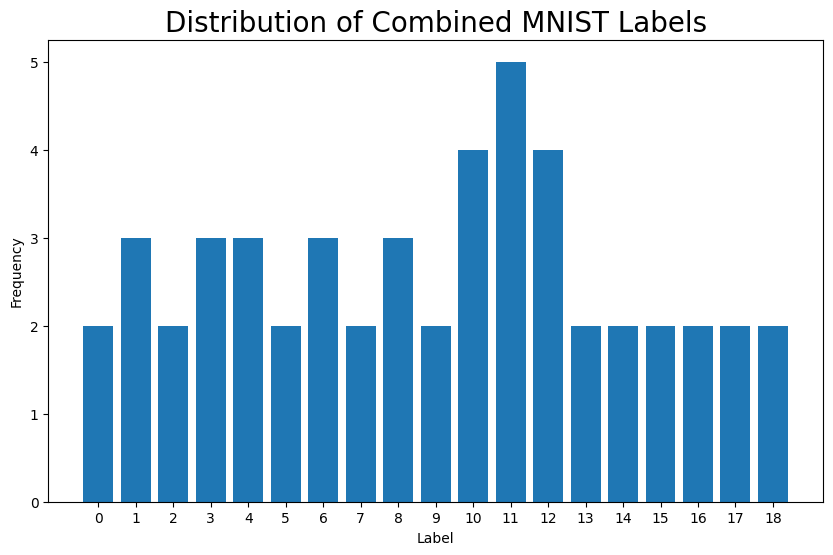

In [6]:
def show_plot():

    X, Y, D1, D2, X1, X2 = jl_dataset(X_in, Y_in, output=50)
        
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.hist(Y, bins=np.arange(20) - 0.5, rwidth=0.8)
    ax.set_title('Distribution of Combined MNIST Labels', fontsize=20)
    ax.set_xlabel('Label')
    ax.set_ylabel('Frequency')
    ax.set_xticks(range(19))  # Labels from 0 to 18
    fig.savefig('Y_dist.png')
    plt.show()

show_plot()

In [7]:
def training_models(X_in, Y_in):
    sizes = [50, 100, 500, 1000, 10000]
    scores = []
    accuracies = []
    classifications = []
    confusions = []
    for size in sizes:
        X, Y = jl_dataset(X_in, Y_in, output=size*2)[:2]
        X = X.reshape(X.shape[0], -1)
        
        train_ratio = 0.5
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-train_ratio), random_state=441)
        y_train = to_categorical(y_train, num_classes)
        y_test = to_categorical(y_test, num_classes)

        model = LogisticRegression(max_iter=1000)
        model.fit(x_train, np.argmax(y_train, axis=1))

        predictions = model.predict(x_test)
        score = model.score(x_test, np.argmax(y_test, axis=1))
        accuracy = accuracy_score(y_true=np.argmax(y_test, axis=1), y_pred=predictions)
        classification = classification_report(y_true=np.argmax(y_test, axis=1), y_pred=predictions, zero_division=0)
        confusion = confusion_matrix(y_true=np.argmax(y_test, axis=1), y_pred=predictions)

        scores.append(score)
        accuracies.append(accuracy)
        classifications.extend(classification)
        confusions.extend(confusion)
        
    return scores, accuracies, classifications, confusions

In [8]:
single_scores, single_accuracies, single_classifications, single_confusions = training_models(X_in, Y_in)

In [9]:
def sequential_models(X_in, Y_in):
    sizes = [50, 100, 500, 1000, 10000]
    accuracies = []
    classifications = []
    confusions = []

    for size in sizes:
        X, Y, D1, D2, X1, X2 = jl_dataset(X_in, Y_in, output=size*2)
    
        X = X.reshape(X.shape[0], -1)
        X1 = X1.reshape(X1.shape[0], -1)
        X2 = X2.reshape(X2.shape[0], -1)

        train_ratio = 0.5
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=(1-train_ratio), random_state=441)
        x1_train, x1_test, y1_train, y1_test = train_test_split(X1, D1, test_size=(1-train_ratio), random_state=441)
        x2_train, x2_test, y2_train, y2_test = train_test_split(X2, D2, test_size=(1-train_ratio), random_state=441)

        Y_train = to_categorical(Y_train, num_classes)
        Y_test = to_categorical(Y_test, num_classes)
        y1_train = to_categorical(y1_train, num_classes)
        y1_test = to_categorical(y1_test, num_classes)
        y2_train = to_categorical(y2_train, num_classes)
        y2_test = to_categorical(y2_test, num_classes)
        
        model1 = LogisticRegression(max_iter=1000)
        model2 = LogisticRegression(max_iter=1000)

        model1.fit(x1_train, np.argmax(y1_train, axis=1))
        model2.fit(x2_train, np.argmax(y2_train, axis=1))

        pred1 = model1.predict(x1_test)
        pred2 = model2.predict(x2_test)

        predictions = pred1+pred2

        accuracy = accuracy_score(y_true=np.argmax(Y_test, axis=1), y_pred=predictions)
        classification = classification_report(y_true=np.argmax(Y_test, axis=1), y_pred=predictions, zero_division=0)
        confusion = confusion_matrix(y_true=np.argmax(Y_test, axis=1), y_pred=predictions)

        accuracies.append(accuracy)
        classifications.extend(classification)
        confusions.extend(confusion)

    return accuracies, classifications, confusions

In [10]:
seq_accuracies, seq_classifications, seq_confusions = sequential_models(X_in, Y_in)

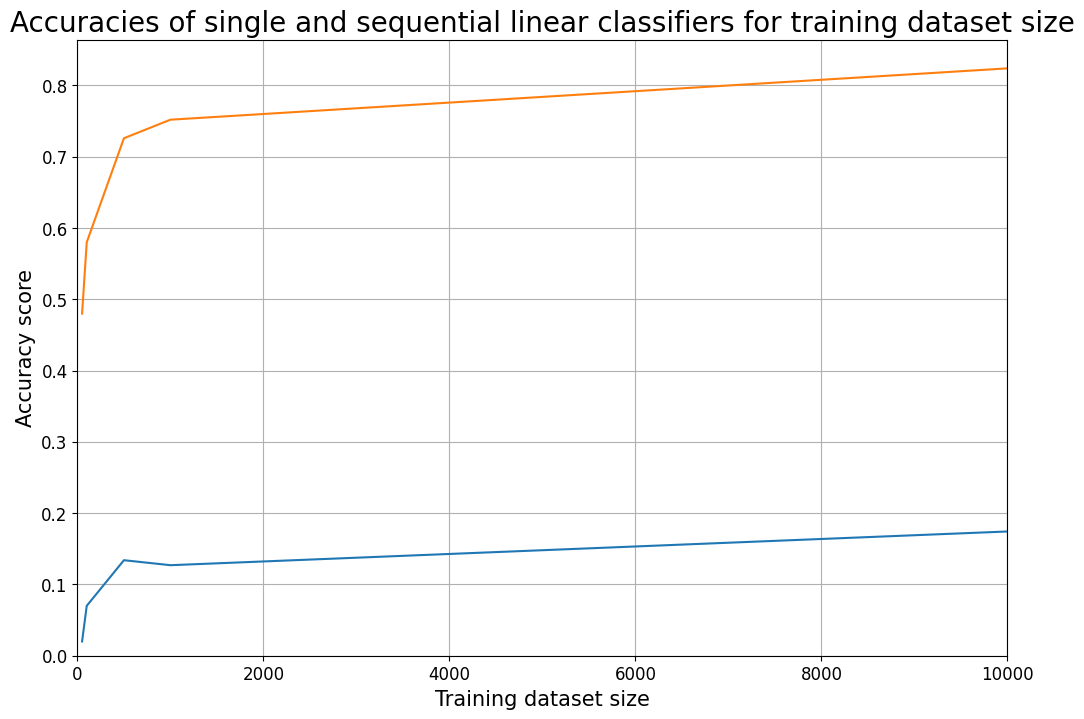

In [22]:
def compare_plot(single_accuracies, seq_accuracies):
    sizes = [50, 100, 500, 1000, 10000]
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(sizes, single_accuracies, label="Single linear classifier")
    ax.plot(sizes, seq_accuracies, label="Sequential linear classifiers")
    ax.set_xlabel("Training dataset size")
    ax.set_ylabel("Accuracy score")
    ax.set_xlim(0,10000)
    ax.set_ylim(0, None)
    ax.set_title("Accuracies of single and sequential linear classifiers for training dataset size", fontsize=20)
    plt.grid()
    plt.savefig("classifier_compare.png")
    plt.show()
    

compare_plot(single_accuracies, seq_accuracies)